#Demonstration: Stock Price Forecasting using ARIMA

#Scenario

- TechNova Inc., a rapidly growing tech firm, wants to forecast its stock prices to help guide short-term investment decisions. Your task is to build a time series forecasting pipeline using ARIMA models to predict future stock closing prices.

##Import Required Libraries

- These libraries are used for data loading, visualization, ARIMA modeling, and performance evaluation.

In [ ]:
!pip install numpy==1.24.4
!pip install --force-reinstall --no-cache-dir pmdarima

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

##Load and Prepare Dataset

- Stock markets follow business days (Monday to Friday), hence we use 'B' frequency.

In [2]:
# Load the data
df = pd.read_csv("technova_stock.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df.asfreq('B')  # Ensure business day frequency

# Check structure
df.head()

,Close
Date,
2022-01-03,100.993428
2022-01-04,100.655150
2022-01-05,103.153536
2022-01-06,105.820335
2022-01-07,103.206623


##Visualize the Stock Price Trend

- Helps observe trends, seasonality, or anomalies in data.

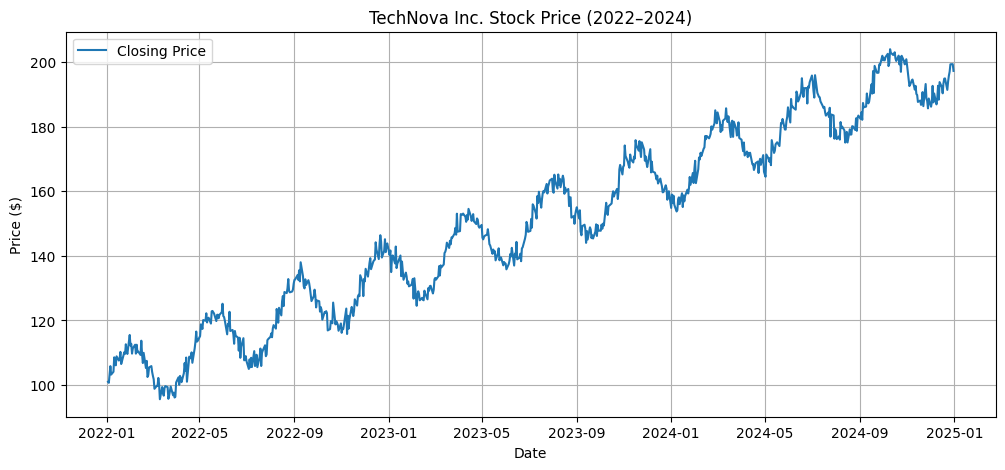

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Closing Price')
plt.title("TechNova Inc. Stock Price (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

##Train-Test Split (Time-Based)

We use the last 3 months (~60 business days) as a test set to simulate real-world prediction.

In [4]:
train = df.iloc[:-60]
test = df.iloc[-60:]

print(f"Train size: {len(train)} | Test size: {len(test)}")

Train size: 722 | Test size: 60


##Stationarity Check (ADF Test)

- ARIMA requires the data to be stationary (mean and variance should not change over time).



In [5]:
result = adfuller(train['Close'].dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

ADF Statistic: -1.0322
p-value: 0.7413


##Manual ARIMA (Baseline Model)

- We use (5,1,2) as a reasonable starting point.

In [6]:
manual_model = ARIMA(train['Close'], order=(5, 1, 2))
manual_fit = manual_model.fit()
manual_forecast = manual_fit.forecast(steps=len(test))

##Auto ARIMA (Automated Tuning)

In [7]:
auto_model = pm.auto_arima(train['Close'], seasonal=False, stepwise=True,
                           suppress_warnings=True, error_action='ignore')
auto_forecast = auto_model.predict(n_periods=len(test))

##Evaluate Model Performance (Test Set)

In [12]:
manual_rmse = np.sqrt(mean_squared_error(test['Close'], manual_forecast))
manual_mape = mean_absolute_percentage_error(test['Close'], manual_forecast)

auto_rmse = np.sqrt(mean_squared_error(test['Close'], auto_forecast))
auto_mape = mean_absolute_percentage_error(test['Close'], auto_forecast)

print(f"Manual ARIMA (5,1,2): RMSE = {manual_rmse:.2f}, MAPE = {manual_mape*100:.2f}%")
print(f"Auto ARIMA {auto_model.order}: RMSE = {auto_rmse:.2f}, MAPE = {auto_mape*100:.2f}%")

Manual ARIMA (5,1,2): RMSE = 5.72, MAPE = 2.39%
Auto ARIMA (1, 1, 5): RMSE = 9.13, MAPE = 4.02%


##Compare Model Metrics

In [13]:
comparison = pd.DataFrame({
    'Model': ['Manual ARIMA (5,1,2)', f'Auto ARIMA {auto_model.order}'],
    'RMSE': [manual_rmse, auto_rmse],
    'MAPE (%)': [manual_mape * 100, auto_mape * 100]
})
print(comparison)

                  Model      RMSE  MAPE (%)
0  Manual ARIMA (5,1,2)  5.720557  2.390228
1  Auto ARIMA (1, 1, 5)  9.131248  4.021733


##Plot Forecast on Test Data (Best Model)


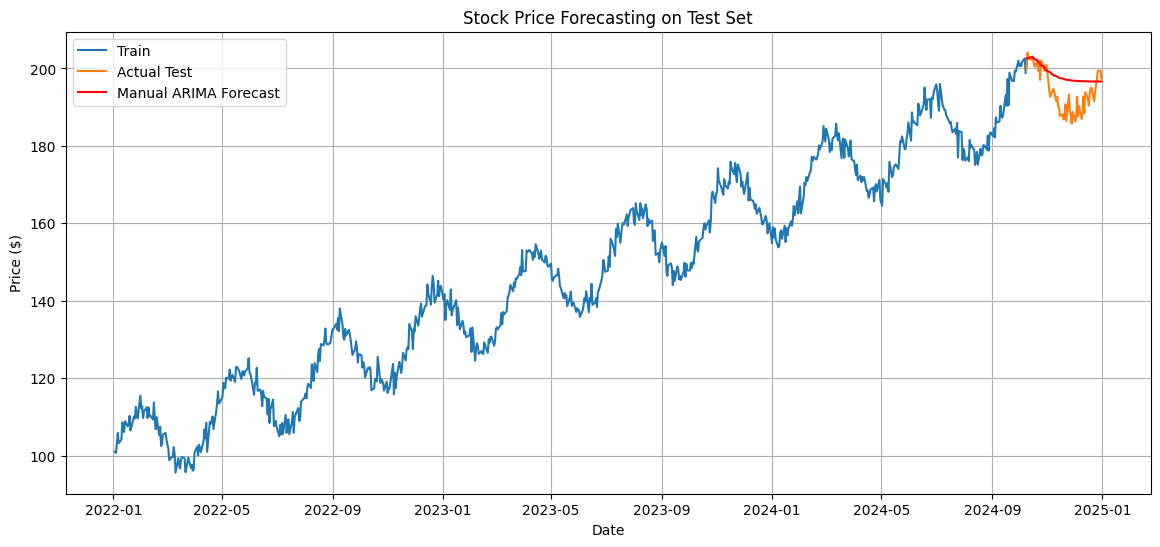

In [14]:
best_forecast = auto_forecast if auto_rmse < manual_rmse else manual_forecast
best_label = "Auto ARIMA" if auto_rmse < manual_rmse else "Manual ARIMA"

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Actual Test')
plt.plot(test.index, best_forecast, label=f'{best_label} Forecast', color='red')
plt.title("Stock Price Forecasting on Test Set")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

##Forecast Future Prices (30 Days)

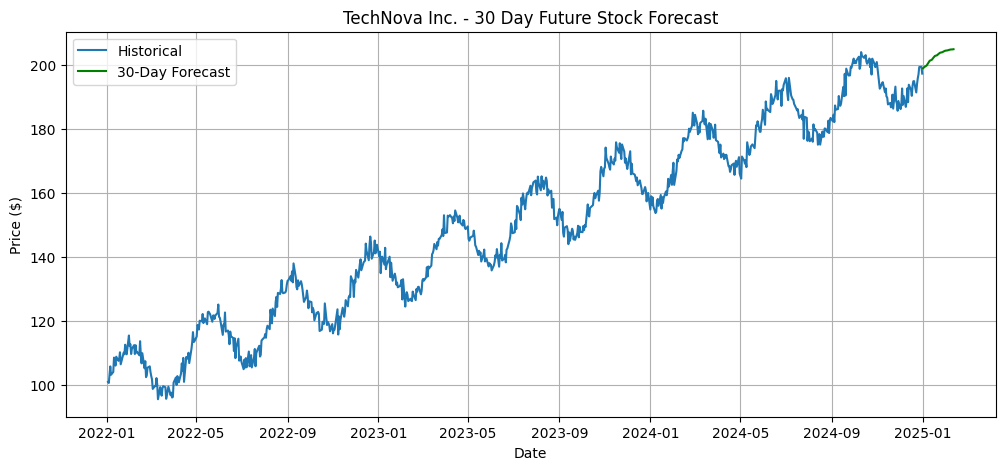

In [15]:
# Refit model on full dataset with best order
best_order = auto_model.order if auto_rmse < manual_rmse else (5, 1, 2)
final_model = ARIMA(df['Close'], order=best_order).fit()

future_forecast = final_model.forecast(steps=30)
future_forecast.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Plot future forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label="Historical")
plt.plot(future_forecast, label="30-Day Forecast", color='green')
plt.title("TechNova Inc. - 30 Day Future Stock Forecast")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

##Save Future Predictions to CSV

- To share forecast data with business teams, analysts, or use in dashboards.

In [16]:
future_df = future_forecast.reset_index()
future_df.columns = ['Date', 'Forecasted_Close']
future_df.to_csv("technova_best_forecast.csv", index=False)